In [1]:
from torch import distributions as dist
from torch import tensor
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import pandas as pd
import torch
import numpy as np
from torch.optim import Adam
from tqdm.auto import tqdm
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch.distributions.constraints as constraints

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Experiment setup

Imagine a randomized controlled trial of a new tool, a documentation searcher, and you measure how long people take to answer a set of questions. Let's assume your tool actually helps, so we'll use two normal distributions to model the response times. We can then simulate an experiment with K participants by assigning half to control and half to treatment.

In [2]:
def participant_control():
    return dist.Normal(10.0, 5.0).sample().item()

def participant_treatment():
    return dist.Normal(15.0, 5.0).sample().item()

def simulate_experiment(K):
    return (
        np.array([participant_control() for _ in range(K//2)]),
        np.array([participant_treatment() for _ in range(K//2)])
    )

In [3]:
simulate_experiment(6)

(array([13.45993042, 13.56696129, 17.61479568]),
 array([20.36636353, 16.10270691, 18.85890007]))

# Issue with significance testing

What if we want to show reviewers that our tool helps? Well of course we run an analysis of variance:

https://hal.inria.fr/hal-01377894/document

In [4]:
control, treatment = simulate_experiment(6) # run simulation several times at different K to see pvalue change
stats.f_oneway(control, treatment)

F_onewayResult(statistic=0.22237815140214331, pvalue=0.6618053210517869)

Oh no it's not significant! Why? How many K do we need?

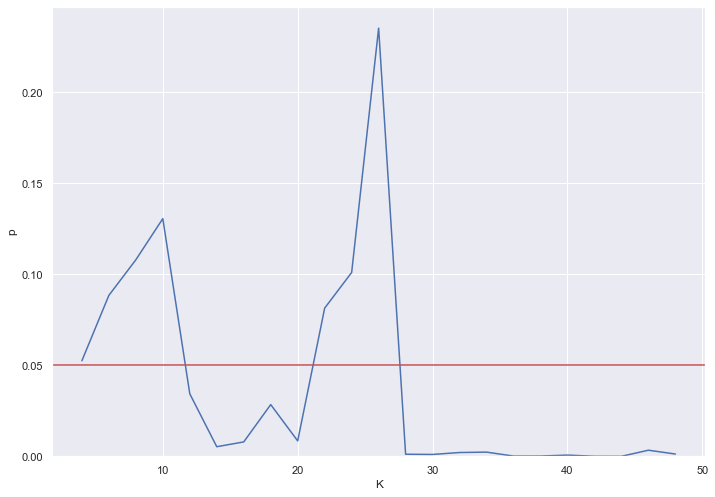

In [5]:
def num_participants_experiment(test):
    return pd.DataFrame([        
        {
            # run graph several times to show why we need multiple simulations at a given K
            'p': test(*simulate_experiment(K)).pvalue,
            'K': K
        }
        for K in range(4, 50, 2)
    ])

def plot_pvalues(data):
    ax = sns.lineplot(data=data, x="K", y="p", ci="sd")
    ax.axhline(0.05, color='r')
    ax.set_ylim(0)        

plot_pvalues(num_participants_experiment(stats.f_oneway))

Just one simulation per K isn't good enough, we need a distribution

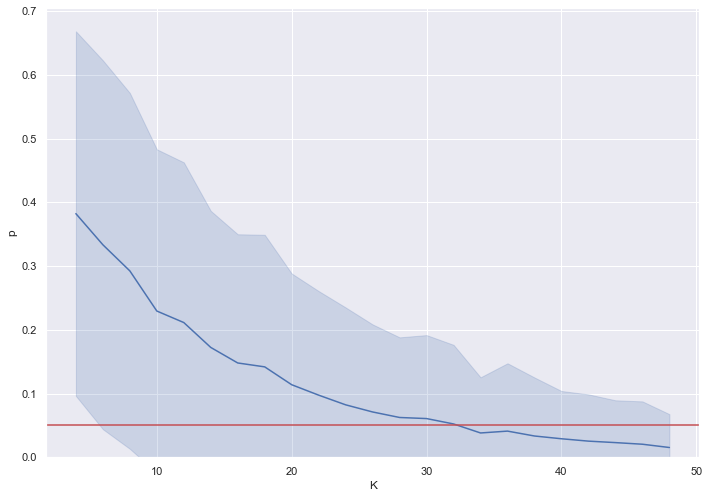

In [6]:
def num_participants_experiment(test):
    return pd.DataFrame([        
        {
            'p': test(*simulate_experiment(K)).pvalue,
            'K': K
        }
        for K in range(4, 50, 2)
        for _ in range(1000)
    ])

plot_pvalues(num_participants_experiment(stats.f_oneway))

Let's test this with a t-test just to see if it changes

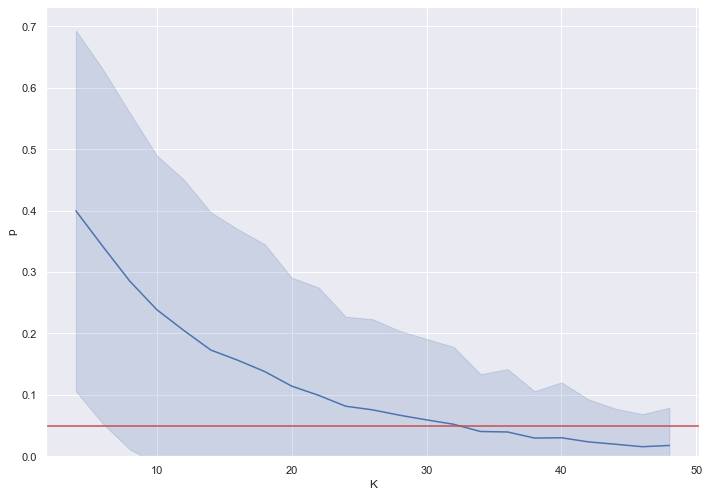

In [7]:
# show how this can be used for another statistical test
plot_pvalues(num_participants_experiment(stats.ttest_ind))

# Testing semantics

So why is our test like this? What does the test actually mean? 

**Q: if your goal was to convince me that these two datasets came from different distributions, w/o knowing the original model, how would you argue for it? Throw away your ideas about null hypothesis, testing, whatever.**

Basic idea: compare the means!

In [8]:
control, treatment = simulate_experiment(20)
print(control.mean() - treatment.mean())

-9.54013967514038


Now let's try and do this several times. 

**Q: What do we expect the distribution to look like?**

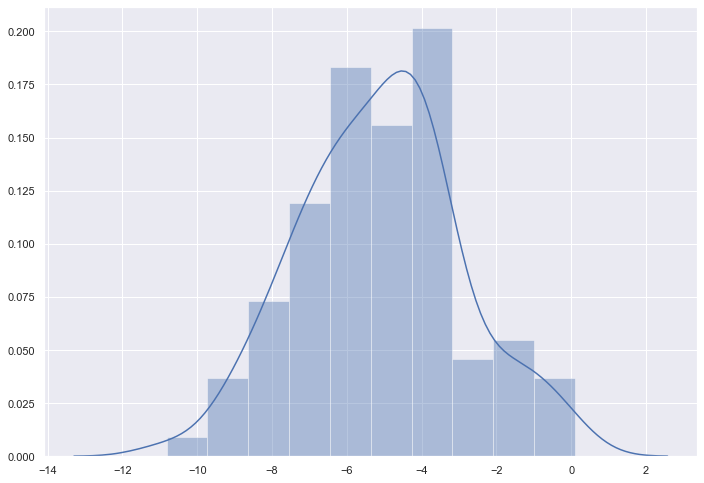

In [9]:
# look at distribution of meandiff statistic through simulation

def meandiff(control, treatment):
    return control.mean() - treatment.mean()

sns.distplot([meandiff(*simulate_experiment(20)) for _ in range(100)])

The basic intution is that if, on average, this is not zero, then we can deduce that the two distributions are not the same. So the difference in means is a statistic, and checking if it's non-zero is a test. But the issue is that a mean doesn't reflect the amount of data being used to compute the mean. For example, let's compare against the distribution of mean differences for 4 participants and 80 participants:

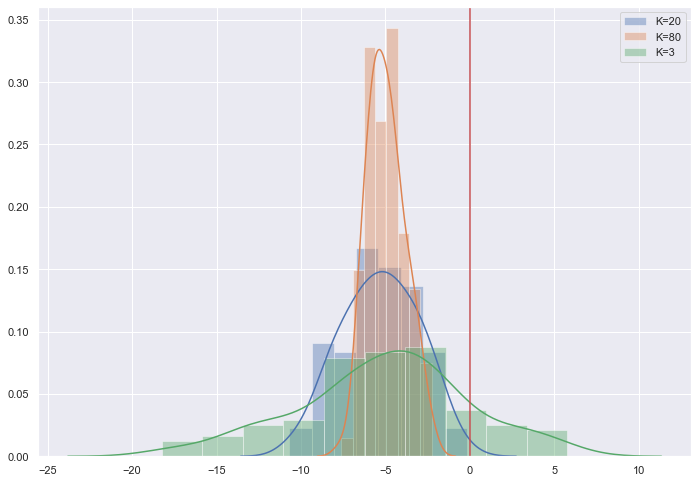

In [10]:
sns.distplot([meandiff(*simulate_experiment(20)) for _ in range(100)], label='K=20')
sns.distplot([meandiff(*simulate_experiment(80)) for _ in range(100)], label='K=80')
ax = sns.distplot([meandiff(*simulate_experiment(4)) for _ in range(100)], label='K=3')
ax.axvline(0, color='r')
plt.legend()

At least ~30% of the time, with 4 participants we're likely to get a statistic that says the mean difference is 0 or greater. That doesn't leave us with great confidence that the two distributions are difference at K=3, unlike K=20 which intersects with 0 a really small number of times. 

When we think about this as a statistical test, it's framed against the "null hypothesis", which is the belief that the treatment group has the same mean as the control group. We can simulate the null hypothesis by computing the distribution of the mean difference statistic against two different sets of control participants.

**Q: what is the mean of this distribution going to be?**

In [11]:
# contrast with null hypothesis distribution
sns.distplot([meandiff(
    np.array([participant_control() for _ in range(20)]),
    np.array([participant_control() for _ in range(2N0)])
) for _ in range(100)])

SyntaxError: invalid syntax (<ipython-input-11-9b8ce5d0e273>, line 4)

This is a normal distribution centered at 0, which makes sense -- the difference in means should average out to zero. The other key idea is that the distribution shows a reasonable range of individual values to get for the difference of means statistic. So if we ran the experiment and saw the treatment had a mean difference of -2, that wouldn't necessarily be that surprising, it still has maybe a 15% probability under the null hypothesis model.

And this is the main idea that I didn't really understand about statistical testing. When you have two groups of measurements, something like difference of means, a statistic, has a distribution. Not the original data, but the statistic itself. A null hypothesis is the distribution over a particular test statistic, like T or F or differenc e of means, when comparing a population against itself, like the control. 

Then a statistical test asks the question: how likely is a particular statistic under the null hypothesis distribution? For example, if we observed a difference in means of -6, that's extremely unlikely under the null hypothesis. Hence, that would give us evidence to reject the null hypothesis, and assume the means are different.

Does that make sense? Any questions about that?

Now, one issue we haven't addressed: this notion of statistical testing makes sense, assuming we know what the true control or treatment distributions are. But we don't, that's the whole point of experimental data. We have to assume that both the mean and the variance of the data are unknown.

At this point, we can use some math based on the properties of the normal distribution to arrive at a better statistic, one which we can use for a test without knowing the true mean or variance. I'm not going to go through the math, but the basic idea is to normalize the difference in means by the standard deviation in the data. Then our test statistic is guaranteed to have mean 0 and standard deviation 1 if the control and treatment are from the same distribution.

In [ ]:
def meandiff_norm(control, treatment):
    return (control.mean() - treatment.mean()) / (control.std() + treatment.std()) * 4

ax = sns.distplot([dist.Normal(0, 1).sample() for _ in range(100)], label='N(0, 1)')
sns.distplot([meandiff_norm(
    np.array([participant_control() for _ in range(10)]),
    np.array([participant_control() for _ in range(10)])
) for _ in range(100)], label='null hypothesis')
plt.legend()

So now, we can compare the distribution of the test statistic for our actual treatment against the null hypothesis, N(0,1).

**Q: given this plot, if we look back at the other plot showing the distribution of P-values for the t-test at different levels of K, what should we expect to be the relative fraction of simulations below 0.05?**


In [ ]:
ax = sns.distplot([dist.Normal(0, 1).sample() for _ in range(1000)], label='null hypothesis')
ax.axvline(-1.96, color='r')
sns.distplot([stats.ttest_ind(*simulate_experiment(20)).statistic for _ in range(1000)], label='alternative hypothesis K = 20')
#sns.distplot([stats.ttest_ind(*simulate_experiment(60)).statistic for _ in range(1000)], label='alternative hypothesis K = 60')

plt.legend()

And so that's the idea of a statistical test. You come up with some kind of test statistic, like difference of means, which describes the similarity of two distributions. Assuming the distributions are normal, you can change the statistic such that it follows a known distribution like N(0, 1). Then the p-value corresponds to the probability of the observed statistic under the null hypothesis model.

# Experiment #2

Time permitting, I want to talk about a more interesting example where hypothesis testing becomes less obvious. Consider a randomized controlled trial with a 5-point Likert scale as the measure. In this trial, there are happy people and grumpy people. Let's say the trial is a Sublime Text extension, and the grumpy people only like Vim. In the control setting, with normal Sublime, the grumpy people are grumpy and the happy people like Sublime normally. 

In the treatment, the happy people like your change, but the grumpy people just get angrier at this complicated text editor when they could be using Vim. We'll encode this as another probabilistic simulation.

In [ ]:
def participant_control():
    grumpy = dist.Bernoulli(0.25).sample()
    return dist.Categorical(tensor([0.6, 0.4, 0, 0., 0.])).sample() * grumpy + \
        dist.Categorical(tensor([0, 0.0, 0.1, 0.4, 0.5])).sample() * (1 - grumpy)

def participant_treatment():
    grumpy = dist.Bernoulli(0.25).sample()
    return dist.Categorical(tensor([0.8, 0.2, 0, 0., 0.])).sample() * grumpy + \
        dist.Categorical(tensor([0, 0.0, 0.0, 0.3, 0.7])).sample() * (1 - grumpy)

def simulate_experiment(K):
    return (
        np.array([participant_control() for _ in range(K//2)]),
        np.array([participant_treatment() for _ in range(K//2)])
    )

**Q: What do you expect the distribution of responses to look like for the control and treatment?**

In [ ]:
control, treatment = simulate_experiment(100)
sns.distplot(control, label='control', kde=False, bins=list(range(6)))

In [ ]:
sns.distplot(treatment, label='treatment', kde=False, bins=list(range(6)))

Now, let's look at the raw numbers. More people actually rated our tool a 5! A success. This is what we want to convince our paper reviewers, that the tool was a smash hit in our target demographic. But now let's say we run a t-test. 

**Q: What do we expect to find?**

In [ ]:
stats.ttest_ind(control, treatment)

Yes, the test is not statistically significant because the mean didn't change! We have two bimodal distributions between the control and treatment groups, but the mean doesn't move very much. So when we use a t-test with a normality assumption, this breaks down. Similarly for an f-test. Even for tests that don't make a normality assumption, we get a non-significant result:

In [ ]:
stats.kruskal(control, treatment)

**Q: what would you do in this situation?**

Here's one idea: let's use some machine learning. If we see a bimodal distribution, we can model the responses as a combination of multiple normal distributions, i.e. a Gaussian mixture. We fit a model to the data, sort each data to a cluster, and then get back the corresponding means and standard deviations.

In [ ]:
def get_components(data):
    mixture = GaussianMixture(n_components=2)
    labels = mixture.fit_predict(data.reshape(-1, 1))
    return mixture.means_[:, 0], np.sqrt(mixture.covariances_)[:, 0, 0], \
        [len(labels) - labels.sum(), labels.sum()]

mean1, std1, n1 = get_components(control)
mean2, std2, n2 = get_components(treatment)

To compare differences in just the happy group, we can now do a t-test on the two high-mean components:

In [ ]:
i = np.argmax(mean1)
j = np.argmax(mean2)

stats.ttest_ind_from_stats(mean1[i], std1[i], n1[i], mean2[j], std2[j], n2[j], equal_var=False)

You can combine learning techniques like a Gaussian mixture with a statistical test to separate out otherwise insignificant effects!

But the last thing I want to point out is that demonstrating statistical signifiance is just step one. What you really want to understand is the strength of your treatment. There's a lot of literature on effect sizes and so on, but I want to show a different perspective about parameter estimation. We'll use a new technology called a probabilistic program...

In [ ]:
import pyro.distributions as dist

def participant_model(y):
    grumpy = pyro.sample('grumpy', dist.Bernoulli(0.5))
    grumpy_likert = pyro.sample('grumpy_likert', dist.Normal(1. + -1 * y, 1.0))
    happy_likert = pyro.sample('happy_likert', dist.Normal(3. + 1 * y, 1.0))
    return pyro.sample('likert', dist.Normal(grumpy * grumpy_likert + (1. - grumpy) * happy_likert, 1.))

def participant_guide(y):
    prob_grumpy = pyro.param("prob_grumpy", tensor(0.5), constraint=constraints.interval(0, 1))
    grumpy = pyro.sample('grumpy', dist.Bernoulli(prob_grumpy))
    
    grumpy_mean = pyro.param("grumpy_mean", tensor(1.))
    grumpy_alpha = pyro.param("grumpy_alpha", tensor(-1.))
    grumpy_std = pyro.param("grumpy_std", tensor(1.), constraint=constraints.positive)
    happy_mean = pyro.param("happy_mean", tensor(3.))
    happy_alpha = pyro.param("happy_alpha", tensor(1.))
    happy_std = pyro.param("happy_std", tensor(1.), constraint=constraints.positive)
    
    pyro.sample('grumpy_likert', dist.Normal(grumpy_mean + grumpy_alpha * y, grumpy_std))
    pyro.sample('happy_likert', dist.Normal(happy_mean + happy_alpha * y, happy_std))        

all_data = torch.cat((tensor(control), tensor(treatment)))
mask = torch.cat((torch.zeros(len(control)), torch.ones(len(treatment))))

cond_model = pyro.condition(participant_model, {'likert': all_data})

pyro.clear_param_store()
optimizer = Adam({'lr': 0.005})
svi = SVI(cond_model, participant_guide, optimizer, Trace_ELBO())
losses = []
for i in tqdm(range(10000)):
    loss = svi.step(mask)
    losses.append(loss)

In [ ]:
for k in ['prob_grumpy', 'grumpy_mean', 'grumpy_alpha', 'grumpy_std', 'happy_mean', 'happy_alpha', 'happy_std']:
    print(k, pyro.param(k).item())


In [ ]:
print('Gaussian mixture happy mean (control): ', np.max(mean1))
print('Gaussian mixture happy mean (treatment): ', np.max(mean2))
print('Gaussian mixture grumpy mean (control): ', np.min(mean1))
print('Gaussian mixture grumpy mean (treatment): ', np.min(mean2))
print('PPL happy mean (control): ', pyro.param('happy_mean').item())
print('PPL happy mean (treatment): ', pyro.param('happy_mean').item() + pyro.param('happy_alpha').item())
print('PPL grumpy mean (control): ', pyro.param('grumpy_mean').item())
print('PPL grumpy mean (treatment): ', pyro.param('grumpy_mean').item() + pyro.param('grumpy_alpha').item())